# Install Necessarly Libraries

In [1]:
!pip install --upgrade setuptools==66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip uninstall -y gym
!git clone https://github.com/openai/gym.git
%cd gym
!git checkout tags/v0.21.0
!pip install -e .

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Cloning into 'gym'...
remote: Enumerating objects: 16503, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 16503 (delta 2), reused 2 (delta 0), pack-reused 16497
Receiving objects: 100% (16503/16503), 6.95 MiB | 22.02 MiB/s, done.
Resolving deltas: 100% (11629/11629), done.
/content/gym
Note: switching to 'tags/v0.21.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to fa

In [3]:
!pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests
!pip install box2d-py
!pip install gym[box2d]
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install --upgrade "importlib_metadata<5.0"
!pip install pyglet==1.4.11
!apt install swig cmake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/carlosluis/stable-baselines3 (to revision fix_tests) to /tmp/pip-req-build-y39w3isc
  Running command git clone --filter=blob:none --quiet https://github.com/carlosluis/stable-baselines3 /tmp/pip-req-build-y39w3isc
  Running command git checkout -b fix_tests --track origin/fix_tests
  Switched to a new branch 'fix_tests'
  Branch 'fix_tests' set up to track remote branch 'fix_tests' from 'origin'.
  Resolved https://github.com/carlosluis/stable-baselines3 to commit 6617e6e73cb3a70f3e88cea780ea12bed95c099e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created 

# Import Libraries

In [4]:
import gym
from gym import ActionWrapper
from gym.spaces import Discrete
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pyvirtualdisplay import Display
from tqdm import tqdm

In [5]:
print(gym.__version__)

0.21.0


# Display Output as Video

In [6]:
# pyvirtusldisplay is only needed if running on a Colab or Kaggle notebook
display = Display(visible=0, size=(1400, 900))
display.start()

def animate(imgs, video_name=None, _return=True):
    # using cv2 to generate videos
    import cv2
    import os
    import string
    import random
    video_name = video_name if video_name is not None else ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'VP80'), 20, (width,height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

# Taxi Environment (Define new actions)
#### new actions are -> Top-Left, Top-Right, Down-Right, Down-Left

In [7]:
class CustomTaxiWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = gym.spaces.Discrete(self.env.action_space.n + 4)  # 10 actions including the custom actions
        self.num_cols = 5
        self.num_rows = 5
    def step(self, action):
        if action in range(6):
            return self.env.step(action)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(self.env.s)
        next_state = self.encode(taxi_row, taxi_col, pass_loc, dest_idx)

        # check if there is obstacles on left, top-left and down-left of the taxi
        top_left_free = self.desc[taxi_row, 2 * taxi_col] == b":"
        left_free = self.desc[1 + taxi_row, 2 * taxi_col] == b":"
        down_left_free = self.desc[2 + taxi_row, 2 * taxi_col] == b":"

        # check if there is obstacles on right, top-right and down-right of the taxi
        top_right_free = self.desc[taxi_row, 2 * taxi_col + 2] == b":"
        right_free = self.desc[1 + taxi_row, 2 * taxi_col + 2] == b":"
        down_right_free = self.desc[2 + taxi_row, 2 * taxi_col + 2] == b":"

        if action == 6 and (top_left_free or left_free):  # Diagonal action: top-left
            next_state = self.encode(max(taxi_row - 1, 0), max(taxi_col - 1, 0), pass_loc, dest_idx)
            # print(action, next_state, max(taxi_row - 1, 0), max(taxi_col - 1, 0), pass_loc, dest_idx)
        elif action == 7 and (top_right_free or right_free):  # Diagonal action: top-right
            next_state = self.encode(max(taxi_row - 1, 0), min(taxi_col + 1, self.num_cols - 1), pass_loc, dest_idx)
            # print(action, next_state, max(taxi_row - 1, 0), min(taxi_col + 1, self.num_cols - 1), pass_loc, dest_idx)
        elif action == 8 and (left_free or down_left_free):  # Diagonal action: down-left
            next_state = self.encode(min(taxi_row + 1, self.num_rows - 1), max(taxi_col - 1, 0), pass_loc, dest_idx)
            # print(action, next_state, min(taxi_row + 1, self.num_rows - 1), max(taxi_col - 1, 0), pass_loc, dest_idx)
        elif action == 9 and (right_free or down_right_free):  # Diagonal action: down-right
            next_state = self.encode(min(taxi_row + 1, self.num_rows - 1), min(taxi_col + 1, self.num_cols - 1), pass_loc, dest_idx)
            # print(action, next_state, min(taxi_row + 1, self.num_rows - 1), min(taxi_col + 1, self.num_cols - 1), pass_loc, dest_idx)
        reward = -1  # Assign a reward of -1 for diagonal actions
        self.env.env.s = next_state  # Update the environment state
        # Update the transition probabilities in env.P for the new actions
        return next_state, reward, False, {}

    def reset(self):
        return self.env.reset()

    def render(self, mode='human'):
        return self.env.render(mode)

    def close(self):
        return self.env.close()

In [8]:
env = gym.make('Taxi-v3')
# Wrap the environment with the custom action wrapper
env = CustomTaxiWrapper(env)

# Q-Learning

In [9]:
# Set hyperparameters
MAX_STEPS_PER_EPISODE = 100
ALPHA = 0.1
EPSILON = 0.1

In [ ]:
def Q_Learning(env, num_episodes, max_steps_per_episode, alpha, discount_factor, epsilon):
  # Q-learning algorithm
  nS = env.observation_space.n
  nA = env.action_space.n
  Q = np.zeros((nS, nA))
  cumulative_rewards = []

  # Create a tqdm progress bar
  progress_bar = tqdm(total=num_episodes, unit='episode')

  for episode in range(num_episodes):
    state = env.reset()
    cumulative_reward = 0
    for step in range(max_steps_per_episode):
        # Exploration-exploitation trade-off
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore: choose a random action
        else:
            action = np.argmax(Q[state, :])  # Exploit: choose the best action based on Q-values

        # Perform the action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        cumulative_reward += reward
        # Update the Q-table using the Q-learning equation
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + discount_factor * np.max(Q[next_state, :]))

        state = next_state
        if done:
            break
    progress_bar.set_description(f'Episode {episode+1}/{num_episodes}')
    progress_bar.update(1)
    cumulative_rewards.append(cumulative_reward)

  progress_bar.close()
  return Q, cumulative_rewards

### Number of Episodes = 5000

Episode 5000/5000: 100%|██████████| 5000/5000 [00:20<00:00, 247.06episode/s]


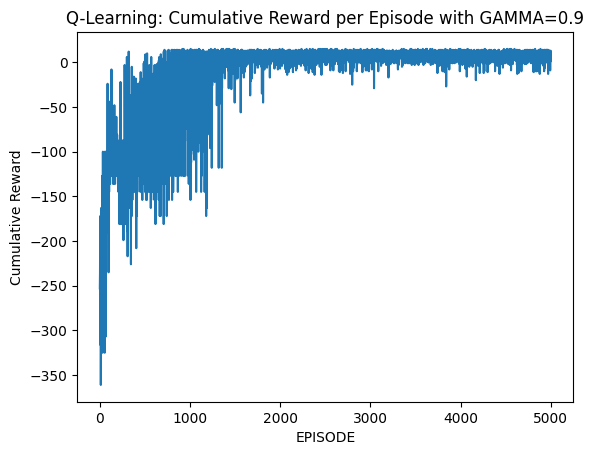

Episode 5000/5000: 100%|██████████| 5000/5000 [00:54<00:00, 91.20episode/s] 


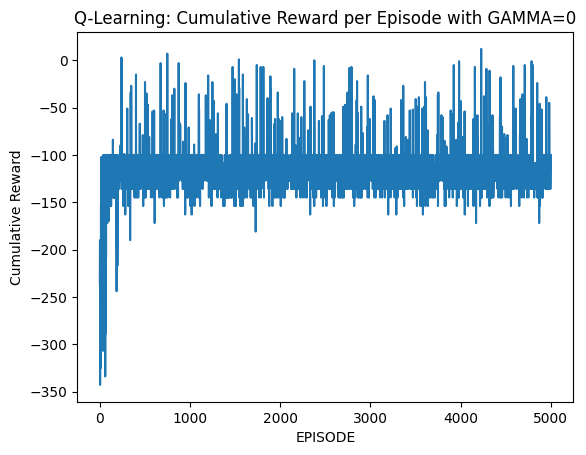

In [ ]:
NUM_EPISODES = 5000
GAMMA = 0.9
q, cumulative_rewards = Q_Learning(env, NUM_EPISODES, MAX_STEPS_PER_EPISODE, ALPHA, GAMMA, EPSILON)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('EPISODE')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
q, cumulative_rewards = Q_Learning(env, NUM_EPISODES, MAX_STEPS_PER_EPISODE, ALPHA, GAMMA, EPSILON)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('EPISODE')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning: Cumulative Reward per Episode with GAMMA=0')
plt.show()

### Number of Episodes = 1000

Episode 1000/1000: 100%|██████████| 1000/1000 [00:07<00:00, 132.62episode/s]


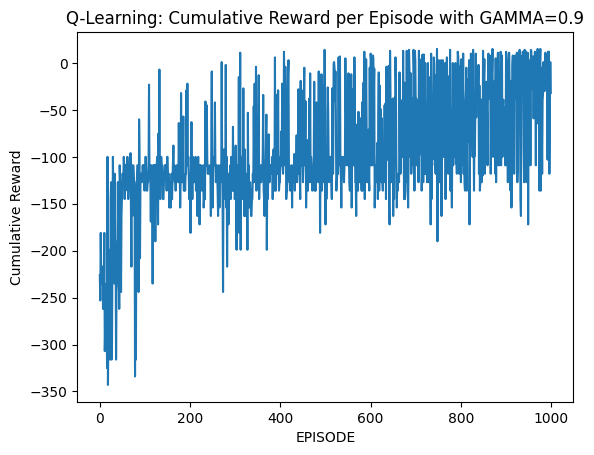

Episode 1000/1000: 100%|██████████| 1000/1000 [00:08<00:00, 123.46episode/s]


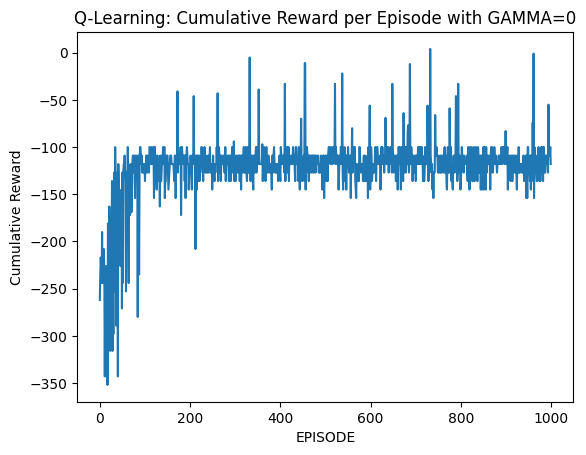

In [ ]:
NUM_EPISODES = 1000
GAMMA = 0.9
q, cumulative_rewards = Q_Learning(env, NUM_EPISODES, MAX_STEPS_PER_EPISODE, ALPHA, GAMMA, EPSILON)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('EPISODE')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
q, cumulative_rewards = Q_Learning(env, NUM_EPISODES, MAX_STEPS_PER_EPISODE, ALPHA, GAMMA, EPSILON)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('EPISODE')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning: Cumulative Reward per Episode with GAMMA=0')
plt.show()

# MC First-Visit

In [ ]:
def epsilon_soft_policy(Q, state, epsilon):
    nA = Q.shape[1]
    best_action = np.argmax(Q[state])
    probabilities = np.ones(nA) * epsilon / nA
    probabilities[best_action] += 1 - epsilon
    probabilities /= np.sum(probabilities)  # Normalize the probabilities
    return probabilities

def MC_Control_OnPolicy(env, num_episodes, epsilon, gamma):
    nA = env.action_space.n
    nS = env.observation_space.n
    returns_sum = np.zeros((nS, nA))
    returns_count = np.zeros((nS, nA))
    Q = np.zeros((nS, nA))
    policy = np.ones((nS, nA)) / nA
    cumulative_rewards = []
    progress_bar = tqdm(total=num_episodes, unit='episode')

    for episode in range(num_episodes):
        episode_states = []
        episode_actions = []
        episode_rewards = []

        state = env.reset()
        done = False

        # Generate an episode
        while not done:
            action = np.random.choice(np.arange(nA), p=policy[state])
            next_state, reward, done, _ = env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state

        G = 0  # Cumulative return
        visited = set()

        # Update action-value function and policy
        for t in reversed(range(len(episode_states))):
            state = episode_states[t]
            action = episode_actions[t]
            reward = episode_rewards[t]
            G = gamma * G + reward

            # Check if it is the first visit to the (state, action) pair
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[state, action] += G
                returns_count[state, action] += 1
                Q[state, action] = returns_sum[state, action] / returns_count[state, action]

                # Update policy
                max_action_value = np.max(Q[state])
                for a in range(nA):
                    if Q[state, a] == max_action_value:
                        policy[state, a] = 1 - epsilon + epsilon / nA
                    else:
                        policy[state, a] = epsilon / nA
                policy[state] /= np.sum(policy[state])  # Normalize the probabilities

        progress_bar.set_description(f'Episode {episode+1}/{num_episodes}')
        progress_bar.update(1)
        cumulative_rewards.append(sum(episode_rewards))

    progress_bar.close()
    return Q, policy, cumulative_rewards

### Number of Episodes = 5000

Episode 5000/5000: 100%|██████████| 5000/5000 [01:50<00:00, 45.16episode/s]


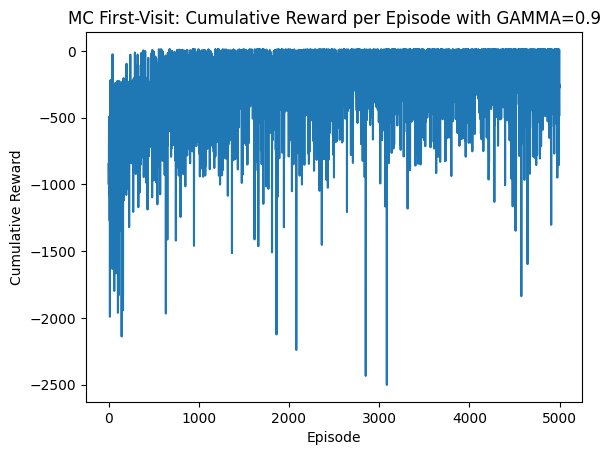

Episode 5000/5000: 100%|██████████| 5000/5000 [02:55<00:00, 28.57episode/s]


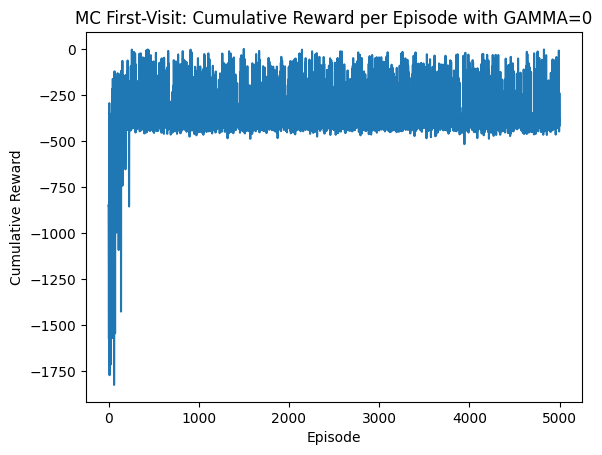

In [ ]:
NUM_EPISODES = 5000
GAMMA = 0.9
q, policy, cumulative_rewards = MC_Control_OnPolicy(env, NUM_EPISODES, EPSILON, GAMMA)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('MC First-Visit: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
q, policy, cumulative_rewards = MC_Control_OnPolicy(env, NUM_EPISODES, EPSILON, GAMMA)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('MC First-Visit: Cumulative Reward per Episode with GAMMA=0')
plt.show()

### Number of Episodes = 1000

Episode 1000/1000: 100%|██████████| 1000/1000 [00:32<00:00, 30.50episode/s]


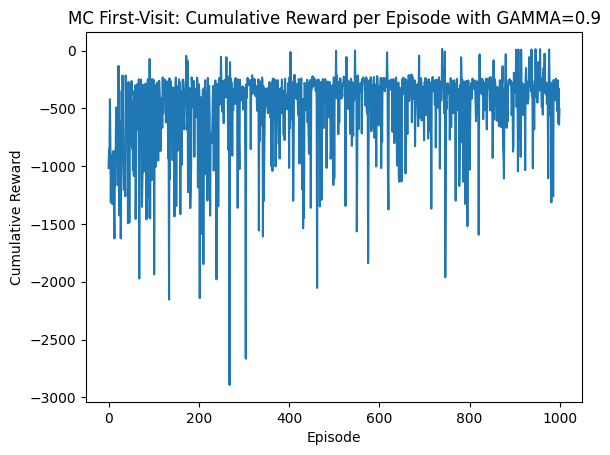

Episode 1000/1000: 100%|██████████| 1000/1000 [00:33<00:00, 29.67episode/s]


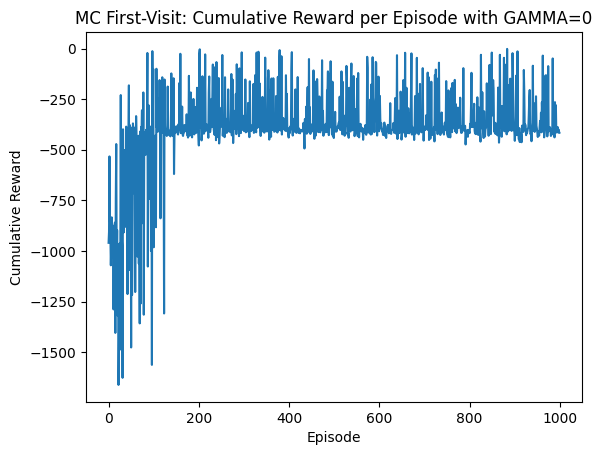

In [ ]:
NUM_EPISODES = 1000
GAMMA = 0.9
q, policy, cumulative_rewards = MC_Control_OnPolicy(env, NUM_EPISODES, EPSILON, GAMMA)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('MC First-Visit: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
q, policy, cumulative_rewards = MC_Control_OnPolicy(env, NUM_EPISODES, EPSILON, GAMMA)

plt.plot(range(NUM_EPISODES), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('MC First-Visit: Cumulative Reward per Episode with GAMMA=0')
plt.show()

# Sarsa

In [13]:
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def Sarsa(env, num_episodes, alpha, gamma, epsilon):
    # Initialize Q table
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA))

    # Perform Sarsa updates
    cumulative_rewards = []
    progress_bar = tqdm(total=num_episodes, unit='episode')
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon)

        done = False
        total_reward = 0

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon)

            # Sarsa update
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action
            total_reward += reward
        progress_bar.set_description(f'Episode {episode+1}/{num_episodes}')
        progress_bar.update(1)
        cumulative_rewards.append(total_reward)

    progress_bar.close()
    return Q, cumulative_rewards


### Number of Episodes = 5000

Episode 5000/5000: 100%|██████████| 5000/5000 [00:17<00:00, 287.06episode/s]


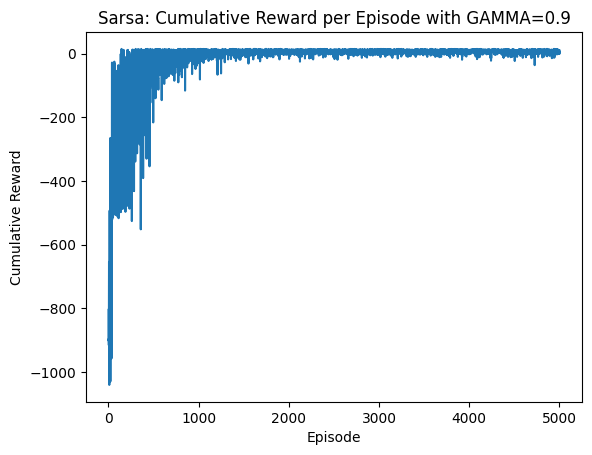

Episode 5000/5000: 100%|██████████| 5000/5000 [01:09<00:00, 71.70episode/s] 


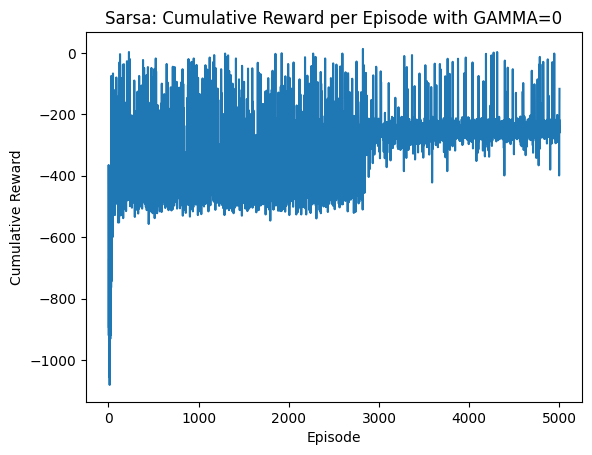

In [14]:
NUM_EPISODES = 5000
GAMMA = 0.9
Q, cumulative_rewards = Sarsa(env, NUM_EPISODES, ALPHA, GAMMA, EPSILON)

# Plot cumulative reward per episode
plt.plot(range(1, NUM_EPISODES+1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Sarsa: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
Q, cumulative_rewards = Sarsa(env, NUM_EPISODES, ALPHA, GAMMA, EPSILON)

# Plot cumulative reward per episode
plt.plot(range(1, NUM_EPISODES+1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Sarsa: Cumulative Reward per Episode with GAMMA=0')
plt.show()

### Number of Episodes = 1000

Episode 1000/1000: 100%|██████████| 1000/1000 [00:06<00:00, 155.38episode/s]


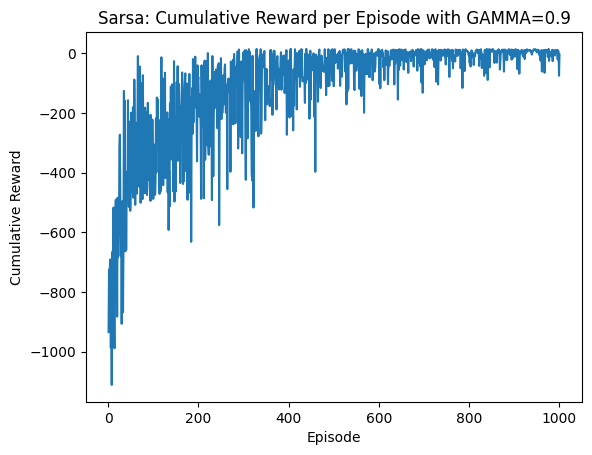

Episode 1000/1000: 100%|██████████| 1000/1000 [00:16<00:00, 59.72episode/s]


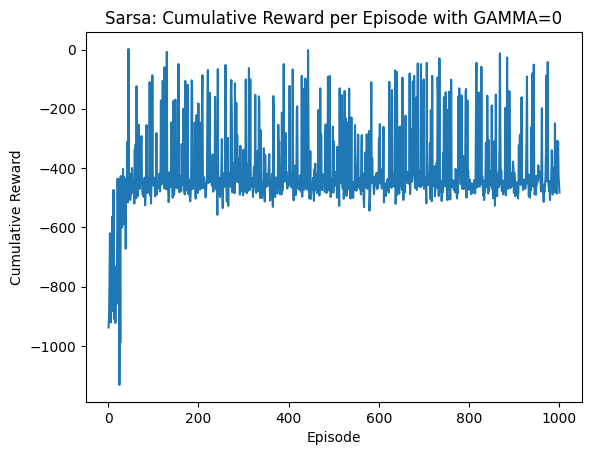

In [15]:
NUM_EPISODES = 1000
GAMMA = 0.9
Q, cumulative_rewards = Sarsa(env, NUM_EPISODES, ALPHA, GAMMA, EPSILON)

# Plot cumulative reward per episode
plt.plot(range(1, NUM_EPISODES+1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Sarsa: Cumulative Reward per Episode with GAMMA=0.9')
plt.show()

GAMMA = 0
Q, cumulative_rewards = Sarsa(env, NUM_EPISODES, ALPHA, GAMMA, EPSILON)

# Plot cumulative reward per episode
plt.plot(range(1, NUM_EPISODES+1), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Sarsa: Cumulative Reward per Episode with GAMMA=0')
plt.show()